In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import ast
import os

# Define Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

class RNA2D_Dataset(Dataset):
    def __init__(self,data):
        self.data=data
        self.tokens={nt:i for i,nt in enumerate('ACGT')}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence=[self.tokens[nt] for nt in self.data.loc[idx,'sequence']]
        sequence=np.array(sequence)
        sequence=torch.tensor(sequence)

        return {'sequence':sequence}

In [ ]:
json_file = '/content/CM_contrafold_2.json.zip'


data = pd.read_json(json_file)

dataset = RNA2D_Dataset(data)

data_reset = data.reset_index(drop=True)

# Save the new dataframe back to a .json file:
data_reset.to_json('reindexed_data.json', orient='records', indent=2)

#verify reset
print(data_reset.head())

dataset = RNA2D_Dataset(data_reset)


4821
                                Dataset  \
0  Leppek, 2021, Nluc mRNA DMS in vitro   
1  Leppek, 2021, Nluc mRNA DMS in vitro   
2  Leppek, 2021, Nluc mRNA DMS in vitro   
3  Leppek, 2021, Nluc mRNA DMS in vitro   
4   Sun, 2019 HEK293 chromatin in vitro   

                                                name  \
0               Leppek, 2021, Nluc mRNA DMS in vitro   
1               Leppek, 2021, Nluc mRNA DMS in vitro   
2               Leppek, 2021, Nluc mRNA DMS in vitro   
3               Leppek, 2021, Nluc mRNA DMS in vitro   
4  Sun, 2019 HEK293 chromatin in vitro ENST000005...   

                                         orig_seqpos  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  [875, 876, 877, 878, 879, 880, 881, 882, 883, ...   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3  [875, 876, 877, 878, 879, 880, 881, 882, 883, ...   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                          reactivity  \
0  [-1

# Define Model

In [ ]:
! pip install einops

In [ ]:
import sys

sys.path.append("/content/ribonanzanet2d-final/")

from Network import *
import yaml

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        self.entries=entries

    def print(self):
        print(self.entries)

def load_config_from_yaml(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return Config(**config)

class finetuned_RibonanzaNet(RibonanzaNet):
    def __init__(self, config):
        config.dropout=0.3
        super(finetuned_RibonanzaNet, self).__init__(config)

        self.dropout=nn.Dropout(0.0)
        self.ct_predictor=nn.Linear(64,1)

    def forward(self,src):

        #with torch.no_grad():
        _, pairwise_features=self.get_embeddings(src, torch.ones_like(src).long().to(src.device))

        pairwise_features=pairwise_features+pairwise_features.permute(0,2,1,3) #symmetrize

        output=self.ct_predictor(self.dropout(pairwise_features)) #predict

        return output.squeeze(-1)

In [ ]:
model=finetuned_RibonanzaNet(load_config_from_yaml("/content/ribonanzanet2d-final/configs/pairwise.yaml")).cuda()

constructing 9 ConvTransformerEncoderLayers


In [ ]:
model.load_state_dict(torch.load("/content/ribonanzanet2d-final/RibonanzaNet-SS.pt",map_location='cpu'))

<ipython-input-7-40bfaf6b5862>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/ribonanzanet2d-final/RibonanzaNet-SS.pt",map_locat

<All keys matched successfully>

In [ ]:
print(len(dataset))

4821


In [ ]:
dataset[0]

{'sequence': tensor([2, 2, 2, 0, 1, 0, 3, 3, 3, 2, 1, 3, 3, 1, 3, 2, 0, 1, 0, 1, 0, 0, 1, 3,
         2, 3, 2, 3, 3, 1, 0, 1, 3, 0, 2, 1, 0, 0, 1, 1, 3, 1, 0, 0, 0, 1, 0, 2,
         0, 1, 0, 1, 1, 0, 3, 2, 3, 2, 2, 1, 3, 0, 2, 3, 0, 0, 2, 1, 1, 3, 1, 2,
         1, 1, 0, 3, 1, 2, 3, 0, 0, 1, 0, 2, 1, 1, 3, 2, 1, 2, 1, 1, 2, 2, 1, 2,
         1, 1, 0, 3, 2, 2, 1, 1, 2, 3, 1, 3, 0, 1, 1, 1, 0, 3, 0, 1, 2, 0, 3, 2,
         3, 0, 1, 1, 0, 2, 0, 1, 3, 0, 1, 2, 1, 1, 2, 2, 1, 3, 0, 1, 1, 1, 1, 3,
         0, 1, 2, 0, 1, 2, 3, 1, 1, 1, 0, 2, 0, 1, 3, 0, 1, 2, 1, 0, 2, 2, 1, 3,
         1, 1, 3, 0, 1, 1, 1, 0, 3, 0, 1, 2, 0, 1, 2, 3, 1, 1, 1, 0, 2, 0, 1, 3,
         0, 1, 2, 1, 0, 2, 2, 0, 3, 1, 0, 2, 2, 1, 2, 3, 1, 3, 3, 1, 0, 1, 0, 1,
         3, 1, 2, 0, 0, 2, 0, 1, 3, 3, 1, 2, 3, 3, 2, 2, 0, 2, 0, 1, 3, 2, 2, 1,
         2, 0, 1, 0, 2, 0, 1, 0, 2, 1, 1, 2, 2, 0, 3, 0, 1, 0, 0, 1, 1, 3, 0, 2,
         0, 1, 1, 0, 0, 2, 3, 1, 1, 3, 0, 2, 0, 2, 1, 0, 0, 2, 2, 0, 2, 2, 0, 2,
         3, 0, 3

# Make predictions

In [ ]:
from tqdm import tqdm
import torch

test_preds = []
model.eval()

for i in tqdm(range(len(dataset))):
    # Access the item correctly for a PyTorch Dataset
    example = dataset[i]
    sequence = example['sequence'].cuda().unsqueeze(0)

    with torch.no_grad():
        test_preds.append(model(sequence).sigmoid().cpu().numpy())





NameError: name 'model' is not defined

In [ ]:
import pickle

# Path to save the file
save_path = '/content/test_preds_new_external_filtered.pkl'

# Save the list of lists to a pickle file
with open(save_path, 'wb') as f:
    pickle.dump(test_preds, f)

print(f"test_preds saved to {save_path}")


In [ ]:
import pickle

# Path to load the file
load_path = '/content/test_preds_all_filtered.pkl'

# Load the list of lists from the pickle file
with open(load_path, 'rb') as f:
    x_dataset_preds = pickle.load(f)

print(f"x_dataset_preds loaded from {load_path}")


x_dataset_preds loaded from /content/test_preds_all_filtered.pkl


14339


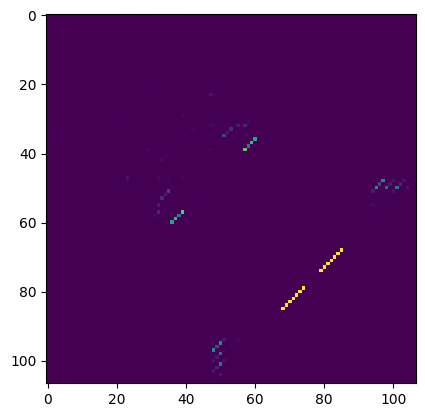

In [ ]:
# let's take a look at the predictions
import matplotlib.pyplot as plt
plt.imshow(x_dataset_preds[0][0])
print(len(x_dataset_preds))

### Convert bpp matrices to punp vectors.

In [ ]:
bpp_vector_list = []
for i in range(len(x_dataset_preds)):
    bpp_vector_list.append(1-np.sum((x_dataset_preds[i][0]), axis=0))

print(len(bpp_vector_list[0]))
len(bpp_vector_list)

107


14339

I truncated the punp vectors to len (79) and then save a .json file that has 'Dataset', 'filename', 'reactivity', and 'p_RibonanzaNet' columns. The 'Dataset' , 'reactivity', and 'filename' values are the same as in input dataframe stored under "data_reset". The 'p_RibonanzaNet' values are from the truncated bpp_vector_list. Both the 'reactivity' and bpp_vectors are trimmed to be a length of 79 values.

In [ ]:
assert len(data_reset) == len(bpp_vector_list)

In [ ]:
len(bpp_vector_list[1])
len(data_reset.iloc[12090]['reactivity'])

103

In [ ]:
data_reset['p_RibonanzaNet'] = bpp_vector_list
len(data_reset.iloc[12090]['p_RibonanzaNet'])

131

In [ ]:
data_reset.head()

,Dataset,ID,MAPseq,chemical,construct,design_name,errors,filename,modifier,passed_CDHIT_filter,...,project_name,reactivity,seqpos,sequence,signal_to_noise,structure,tag,temperature,EternaScore,p_RibonanzaNet
0,Round 00,769337-1,[tag:RTB000],"[MgCl2:10mM, HEPES:50mM(pH8.0)]",EteRNA Cloud Lab,d+m plots weaker again,"[0.3181, 0.42210000000000003, 0.18230000000000...",../data/preprocessing/raw_rdats/ETERNA_R00_000...,[1M7],True,...,Project : Thicker Zigzag,"[0.642, 1.4853, 0.16290000000000002, 0.4096, 0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",GGAAAAAAAAAAAAAAAAAAAAACAAAAAGUGCAUCAUACGAUAAA...,medium:3.227,.............................((((.((((.((((......,None,[24C],68.0,"[0.9557477, 0.9769194, 0.9979502, 0.9991846, 0..."
1,Round 00,766907-1,[tag:RTB000],"[MgCl2:10mM, HEPES:50mM(pH8.0)]",EteRNA Cloud Lab,Slalom take 1,"[0.24760000000000001, 0.4136, 0.1527, 0.206500...",../data/preprocessing/raw_rdats/ETERNA_R00_000...,[1M7],True,...,Project : Thicker Zigzag,"[0.2707, 1.629, 0.1034, 0.29450000000000004, 0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",GGAAAAAAAAAAAAAAAAAAAAACAAAAAGCUCGCAGUAGUACGAA...,medium:2.729,.............................((((.((((.((((......,None,[24C],84.0,"[0.9746439, 0.98744303, 0.99964845, 0.999532, ..."
2,Round 00,766797-1,[tag:RTB000],"[MgCl2:10mM, HEPES:50mM(pH8.0)]",EteRNA Cloud Lab,ZIG 1,"[0.35000000000000003, 0.4867, 0.22840000000000...",../data/preprocessing/raw_rdats/ETERNA_R00_000...,[1M7],True,...,Project : Thicker Zigzag,"[0.6619, 1.8323, 0.2554, 0.09280000000000001, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",GGAAAAAAAAAAAAAAAAAAAAACAAAAACGUGCGGCGACUAGGAA...,medium:2.295,.............................((((.((((.((((......,None,[24C],86.7,"[0.9621384, 0.9459274, 0.9999422, 0.9999056, 0..."
3,Round 00,766205-1,[tag:RTB000],"[MgCl2:10mM, HEPES:50mM(pH8.0)]",EteRNA Cloud Lab,-9.3 kcal,"[0.3116, 0.41440000000000005, 0.1328, 0.1705, ...",../data/preprocessing/raw_rdats/ETERNA_R00_000...,[1M7],True,...,Project : Thicker Zigzag,"[0.7497, 1.6132, 0.007, 0.1378, 0.198700000000...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",GGAAAAAAAAAAAAAAAAAAAAACAAAAAUAUCGCCCGAGUAUGAA...,medium:2.934,.............................((((.((((.((((......,None,[24C],76.0,"[0.97976536, 0.98974127, 0.99930835, 0.9992131..."
4,Round 00,766144-1,[tag:RTB000],"[MgCl2:10mM, HEPES:50mM(pH8.0)]",EteRNA Cloud Lab,Nuttier than a Snickers Bar,"[0.4199, 0.6407, 0.32320000000000004, 0.249600...",../data/preprocessing/raw_rdats/ETERNA_R00_000...,[1M7],True,...,Project : Thicker Zigzag,"[0.4491, 1.6991, 0.21910000000000002, 0.0902, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",GGAAAAAAAAAAAAAAAAAAAAACAAAAACACUACGGGAUGAGAAA...,medium:1.741,.............................((((.((((.((((......,None,[24C],77.3,"[0.97758186, 0.9921096, 0.99972826, 0.99981225..."


In [ ]:
df = data_reset

In [ ]:
import pandas as pd

def trim_vectors(df, col1, col2):
    for index, row in df.iterrows():
        len_col1 = len(row[col1])
        len_col2 = len(row[col2])

        if len_col1 != len_col2:
            # Find the minimum length
            min_len = min(len_col1, len_col2)

            # Trim both columns to the minimum length
            df.at[index, col1] = row[col1][:min_len]
            df.at[index, col2] = row[col2][:min_len]

    return df

df = trim_vectors(df, 'reactivity', 'p_RibonanzaNet')


In [ ]:
df.to_json('/content/CM_RibonanzaNet.json.zip', orient = 'records')

## You can zip the .json file above, and then use it in EternaBench ScoreChemMapping script (Use patched version in gtully github repo) .
## once you have the _BOOTSTRAPS.json.zip file, you can use the CompileBootstrapping python script